In [ ]:
#setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import os

# Set plot style
sns.set_style('whitegrid')

In [ ]:
# Install the Kaggle library
!pip install -q kaggle

# Use Colab's file uploader
from google.colab import files
print("Please upload the kaggle.json file you downloaded from your Kaggle account.")
files.upload()

# Create a directory for the Kaggle API configuration
!mkdir -p ~/.kaggle
# Move the uploaded kaggle.json to the required directory
!cp kaggle.json ~/.kaggle/
# Set the correct permissions for the file
!chmod 600 ~/.kaggle/kaggle.json

print("\nKaggle API configured successfully.")

Please upload the kaggle.json file you downloaded from your Kaggle account.


Saving kaggle.json to kaggle.json

Kaggle API configured successfully.


In [ ]:
# Download the dataset from the 'house-prices-advanced-regression-techniques' competition
!kaggle competitions download -c house-prices-advanced-regression-techniques

# Unzip the downloaded files
!unzip -o house-prices-advanced-regression-techniques.zip

print("\nDataset downloaded and unzipped.")

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 643MB/s]
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               

Dataset downloaded and unzipped.


In [ ]:
# Now, load the data from the unzipped CSV files
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Set the 'Id' column as the index for consistency
train_df.set_index('Id', inplace=True)
test_df.set_index('Id', inplace=True)

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

print("Data loaded successfully:")
train_df.head()

Training data shape: (1460, 80)
Testing data shape: (1459, 79)
Data loaded successfully:


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


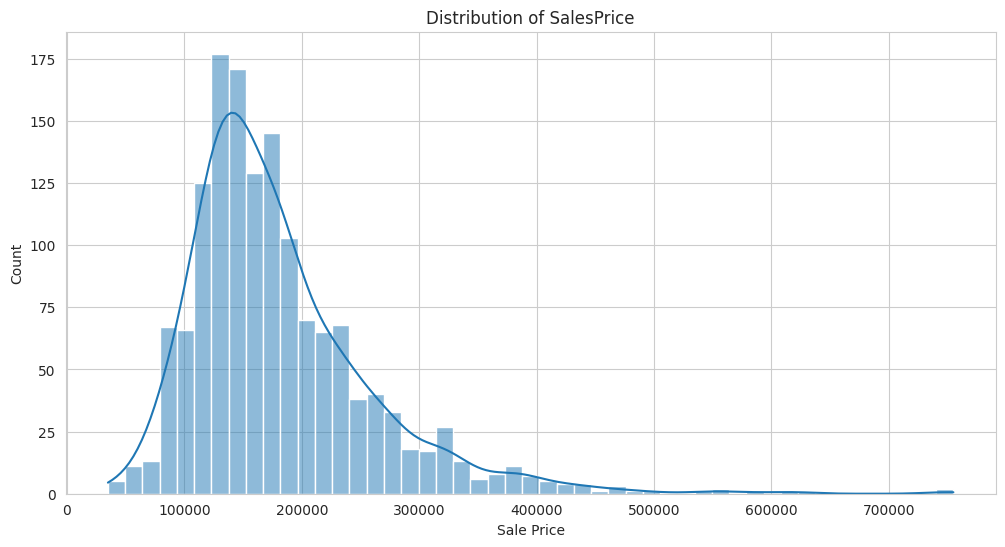

Skewness: 1.8828757597682129


In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(train_df['SalePrice'],kde=True)
plt.xlabel('Sale Price')
plt.title("Distribution of SalesPrice")
plt.show()


print(f"Skewness: {train_df['SalePrice'].skew()}")


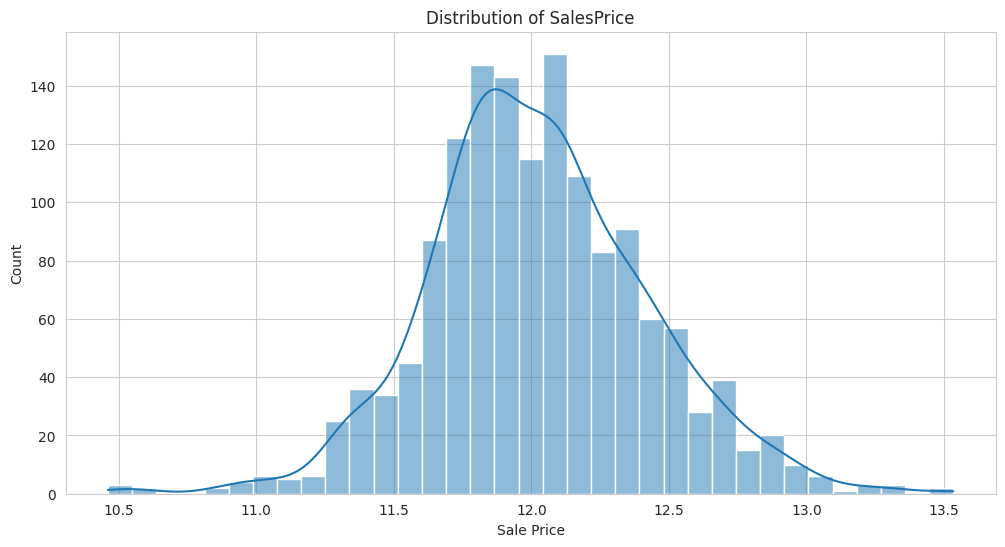

Skewness: 0.12134661989685329


In [ ]:
train_df['SalePrice']=np.log1p(train_df['SalePrice'])

plt.figure(figsize=(12,6))
sns.histplot(train_df['SalePrice'],kde=True)
plt.xlabel('Sale Price')
plt.title("Distribution of SalesPrice")
plt.show()


print(f"Skewness: {train_df['SalePrice'].skew()}")



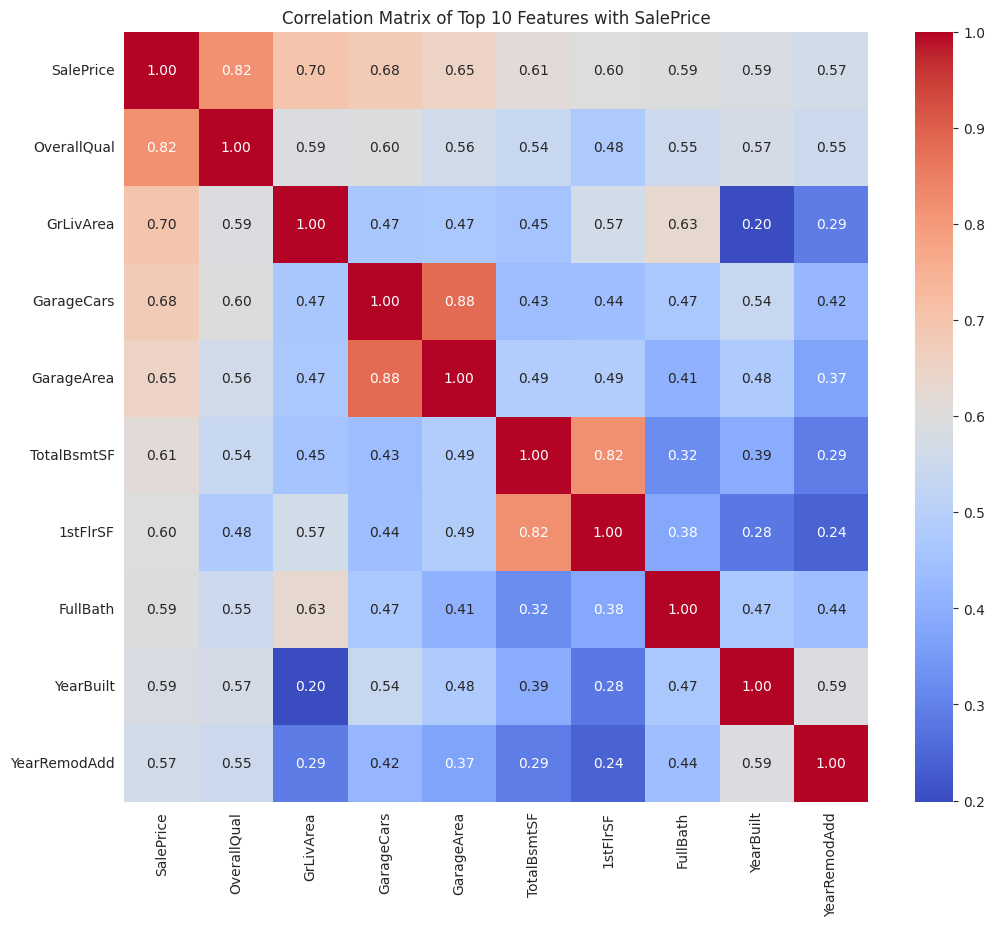

In [ ]:
# Find the top 10 features most correlated with SalePrice
corrmat = train_df.corr(numeric_only=True)
top_corr_features = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
top_corr_matrix = train_df[top_corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Top 10 Features with SalePrice')
plt.show()

In [ ]:
# Combine train and test data for consistent preprocessing
all_data = pd.concat((train_df.loc[:,:'SaleCondition'],
                      test_df.loc[:,:'SaleCondition']))

print(f"Combined data shape: {all_data.shape}")

Combined data shape: (2919, 79)


In [ ]:
missing_data=all_data.isnull().sum().sort_values(ascending=False)
missing_data=missing_data[missing_data>0]
print(missing_data)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Functional         2
BsmtFullBath       2
Utilities          2
Exterior1st        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF1         1
SaleType           1
KitchenQual        1
GarageCars         1
GarageArea         1
Electrical         1
Exterior2nd        1
BsmtFinSF2         1
dtype: int64


In [ ]:
# Impute numerical features with 0
numerical_cols_to_impute_zero = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'BsmtFullBath', 'BsmtHalfBath']
for col in numerical_cols_to_impute_zero:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(0)

In [ ]:
#check num column
all_data[numerical_cols_to_impute_zero].isnull().sum()

,0
MasVnrArea,0
BsmtFinSF1,0
BsmtFinSF2,0
BsmtUnfSF,0
TotalBsmtSF,0
GarageCars,0
GarageArea,0
BsmtFullBath,0
BsmtHalfBath,0


In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 1 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuilt    

In [ ]:
# Impute LotFrontage with the median of the neighborhood
if 'LotFrontage' in all_data.columns and all_data['LotFrontage'].isnull().any():
    all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [ ]:
# Impute categorical features with 'None' (for features where NA means 'no') or mode (for features where NA means missing data)
categorical_cols_to_impute_none = ['Alley', 'Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
for col in categorical_cols_to_impute_none:
    if col in all_data.columns: # Check if column exists after one-hot encoding
        all_data[col] = all_data[col].fillna('None')

for col in ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Utilities', 'Functional', 'MSZoning']:
    if col in all_data.columns: # Check if column exists after one-hot encoding
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [ ]:
# Based on the likely remaining missing values (GarageYrBlt), impute the remaining numerical features.
# GarageYrBlt can be imputed with 0 (assuming 0 means no garage, consistent with GarageArea/Cars=0)
if 'GarageYrBlt' in all_data.columns:
    all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0)


print("\nMissing values after all imputation:", all_data.isnull().sum().sum())


Missing values after all imputation: 0


In [ ]:
# Create a total square footage feature
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Create a total bathrooms feature
all_data['TotalBath'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                         all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

# Create a feature for age of the house at sale
all_data['Age'] = all_data['YrSold'] - all_data['YearBuilt']

print("New features created.")

New features created.


In [ ]:
# Convert any remaining object columns to category type for one-hot encoding
categorical_cols = all_data.select_dtypes(include=['object']).columns
all_data = pd.get_dummies(all_data, columns=categorical_cols, drop_first=True)

print(f"Data shape after encoding: {all_data.shape}")

Data shape after encoding: (2919, 262)


In [ ]:
#other feature enginerring
all_data['Remodel_age']=all_data['YearRemodAdd']-all_data['YearBuilt']

#### **Theoretical Concept: Ordinal vs. Nominal Features**
To use categorical features in a model, we must convert them to numbers. The method depends on the type of feature:
1.  **Ordinal Features:** These have an inherent order (e.g., `Poor < Fair < Good < Excellent`). For these, we use **Label Encoding**, which assigns an integer to each category based on its order (e.g., `Poor=0, Fair=1, ...`).
2.  **Nominal Features:** These have no inherent order (e.g., `Neighborhood`). Using Label Encoding would imply a false order. Instead, we use **One-Hot Encoding**, which creates a new binary (0/1) column for each category.

In [ ]:
# Separate the preprocessed data back into training and testing sets
X = all_data[:len(train_df)]
y = train_df['SalePrice'] # SalePrice was already log-transformed and is only in train_df
X_test_final = all_data[len(train_df):]

# Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X.shape

(1460, 263)

In [ ]:
y.shape

(1460,)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_final_scaled = scaler.transform(X_test_final)

In [ ]:
# xgbr = xgb.XGBRegressor(objective='reg:squarederror', # Corrected objective function
#                         n_estimators=1000,
#                         learning_rate=0.05,
#                         max_depth=3,
#                         min_child_weight=1,
#                         subsample=0.8,
#                         colsample_bytree=0.8,
#                         random_state=42)

# # XGBoost can handle NaNs, but since we've cleaned the data, we can use the scaled data as well if preferred.
# # However, XGBoost generally doesn't require scaling. We'll use the unscaled data as it's a tree-based model.
# xgbr.fit(X_train, y_train)
# y_pred_xgb = xgbr.predict(X_val)

In [ ]:
#Hyperparameter tuning
from sklearn.model_selection import GridSearchCV


#initailaise model
xgbr=xgb.XGBRegressor(objective='reg:squarederror',random_state=42)


#define parameter for regressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3,5,7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 1],
    'reg_lambda': [1, 5, 10]  # L2 regularization
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgbr,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # we want to minimize MSE
    cv=5,
    verbose=2,
    n_jobs=-1
)
#fit the model
grid_search.fit(X_train_scaled,y_train)

#best parameters
print("Best parameters :",grid_search.best_params_)

#best score
print("Best score :",grid_search.best_score_)

best_model=grid_search.best_estimator_
y_pred=best_model.predict(X_val_scaled)




Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters : {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 5, 'subsample': 0.8}
Best score : -0.01597797350136309


In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} Performance ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R-squared: {r2:.4f}\n")

# evaluate_model(y_val, y_pred_lr, "Linear Regression") # Commenting out Linear Regression evaluation as it failed
evaluate_model(y_val, y_pred, "XGBoost")

--- XGBoost Performance ---
RMSE: 0.1374
MAE:  0.0910
R-squared: 0.8988

